In [3]:
# STEP 1: Upload ZIP file manually
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {zip_filename}")

# STEP 2: Extract the ZIP
extract_dir = "/content/citrus_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Detect inner folder if exists
extracted_subdirs = [f for f in os.listdir(extract_dir) if os.path.isdir(os.path.join(extract_dir, f))]
if len(extracted_subdirs) == 1:
    input_dir = os.path.join(extract_dir, extracted_subdirs[0])
else:
    input_dir = extract_dir

print(f"✅ Dataset directory set to: {input_dir}")
print("Subfolders (classes):", os.listdir(input_dir))


# STEP 3: Preprocessing
import cv2
import numpy as np
import pywt

output_dir = "/content/citrus_preprocessed"
os.makedirs(output_dir, exist_ok=True)

# Noise Removal
def remove_noise(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    median = cv2.medianBlur(blur, 5)
    bilateral = cv2.bilateralFilter(median, 9, 75, 75)
    return bilateral

# Image Enhancement
def enhance_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist_eq = cv2.equalizeHist(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(hist_eq)
    return clahe_img

# Edge Detection
def edge_detection(img):
    edges_canny = cv2.Canny(img, 100, 200)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.convertScaleAbs(sobelx + sobely)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    combined_edges = cv2.addWeighted(edges_canny, 0.5, sobel, 0.25, 0)
    combined_edges = cv2.addWeighted(combined_edges, 1.0, laplacian, 0.25, 0)
    return combined_edges

# Discrete Wavelet Transform
def apply_dwt(img):
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    LL = np.uint8(LL)
    return LL

# Resize & Normalize
def resize_and_normalize(img, size=(128, 128)):
    resized = cv2.resize(img, size)
    normalized = (resized / 255.0 * 255).astype(np.uint8)
    return normalized

# Main Preprocessing Loop
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)

    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        denoised = remove_noise(img)
        enhanced = enhance_image(denoised)
        edges = edge_detection(enhanced)
        dwt_img = apply_dwt(edges)
        normalized = resize_and_normalize(dwt_img)

        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, normalized)

print("✅ Preprocessed dataset saved to:", output_dir)


Saving Citrus.zip to Citrus.zip
Uploaded file: Citrus.zip
✅ Dataset directory set to: /content/citrus_dataset/Citrus
Subfolders (classes): ['Canker', 'Greening', 'Melanose', 'Healthy', 'Black spot']
Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Preprocessed dataset saved to: /content/citrus_preprocessed


Segmentation + Data Augumentation

1. GrabCut + Robust Model

In [4]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔹 Input & Output Directories
input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd1"
os.makedirs(output_dir, exist_ok=True)

# 🌿 Background Removal – GrabCut Algorithm
def remove_background(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img.shape[1] - 10, img.shape[0] - 10)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img_cut = img * mask2[:, :, np.newaxis]
    return img_cut

# 🧠 Robust Model Training – Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# 🔄 Apply GrabCut + Augmentation for Each Image
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)

    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Step 1: Background Removal
        bg_removed = remove_background(img)

        # Save the background-removed image
        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, bg_removed)

        # Step 2: Generate Augmented Samples (5 per image)
        img_array = np.expand_dims(bg_removed, axis=0)
        i = 0
        for batch in datagen.flow(
            img_array, batch_size=1,
            save_to_dir=cls_output_path,
            save_prefix='aug', save_format='jpg'
        ):
            i += 1
            if i > 5:  # generate 5 augmented versions
                break

print("✅ Background removal + augmentation complete.")
print("Output dataset saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Background removal + augmentation complete.
Output dataset saved to: /content/sd1


In [5]:
!pip install -q tensorflow scikit-learn joblib tqdm matplotlib

In [1]:
!pip install --upgrade scikit-learn

Loaded 4069 images from /content/sd1
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (4069, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


Saved SOM assignments: /content/op1/som_assignments.npy

Metrics:
 Samples: 4069
Train: 3255
Test: 814
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.6671
Precision: 0.6765
Recall: 0.6671
F1 Score: 0.6660
Specificity (avg): 0.9056
MAE: 0.5332
RMSE: 1.0207



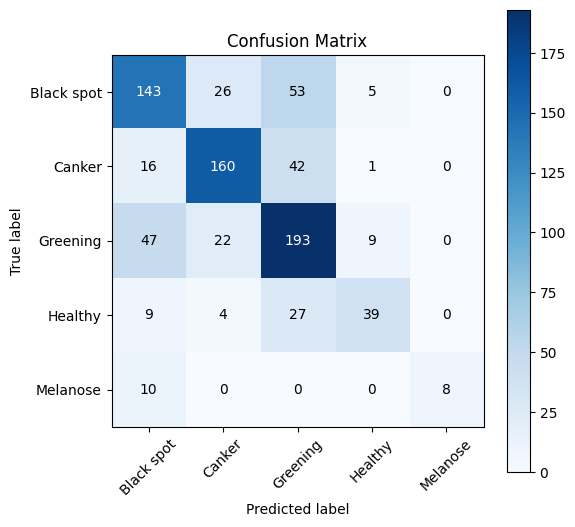

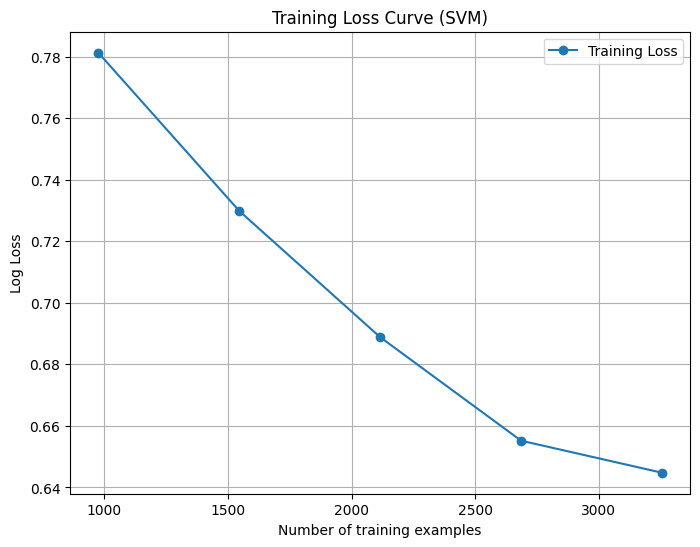

All outputs saved to: /content/op1


In [29]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd1"           # your input preprocessed images
output_dir = "/content/op1"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)


2. GrabCut + Geometric Transform

In [11]:
import cv2
import numpy as np
import os
import random

# 🔹 Input & Output Directories
input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd2"
os.makedirs(output_dir, exist_ok=True)

# 🌿 Background Removal – GrabCut Algorithm
def remove_background(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img.shape[1]-10, img.shape[0]-10)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    return img * mask2[:, :, np.newaxis]

# 🔄 Geometric Transform Functions
def geometric_transform(img):
    rows, cols, ch = img.shape

    # Random Shear
    shear_factor = random.uniform(-0.2, 0.2)
    M_shear = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    img = cv2.warpAffine(img, M_shear, (cols, rows))

    # Random Zoom
    zoom_factor = random.uniform(0.8, 1.2)
    center = (cols // 2, rows // 2)
    M_zoom = cv2.getRotationMatrix2D(center, 0, zoom_factor)
    img = cv2.warpAffine(img, M_zoom, (cols, rows))

    # Random Flip
    if random.random() > 0.5:
        img = cv2.flip(img, 1)  # horizontal flip
    if random.random() > 0.5:
        img = cv2.flip(img, 0)  # vertical flip

    # Random Perspective Warp
    pts1 = np.float32([[0,0], [cols,0], [0,rows], [cols,rows]])
    delta = 0.1 * min(cols, rows)
    pts2 = np.float32([
        [random.uniform(-delta, delta), random.uniform(-delta, delta)],
        [cols + random.uniform(-delta, delta), random.uniform(-delta, delta)],
        [random.uniform(-delta, delta), rows + random.uniform(-delta, delta)],
        [cols + random.uniform(-delta, delta), rows + random.uniform(-delta, delta)]
    ])
    M_pers = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M_pers, (cols, rows))

    return img

# 🔄 Apply GrabCut + Geometric Transforms
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Step 1: Background Removal
        bg_removed = remove_background(img)

        # Save the background-removed image
        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, bg_removed)

        # Step 2: Generate 5 Geometric Transformations
        for i in range(5):
            aug_img = geometric_transform(bg_removed)
            aug_save_path = os.path.join(cls_output_path, f"geo_aug_{i}_{img_file}")
            cv2.imwrite(aug_save_path, aug_img)

print("✅ Background removal + geometric transformations complete.")
print("Output dataset saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Background removal + geometric transformations complete.
Output dataset saved to: /content/sd2


Loaded 3642 images from /content/sd2
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (3642, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


Saved SOM assignments: /content/op2/som_assignments.npy

Metrics:
 Samples: 3642
Train: 2913
Test: 729
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.6612
Precision: 0.6754
Recall: 0.6612
F1 Score: 0.6606
Specificity (avg): 0.9032
MAE: 0.5418
RMSE: 1.0150



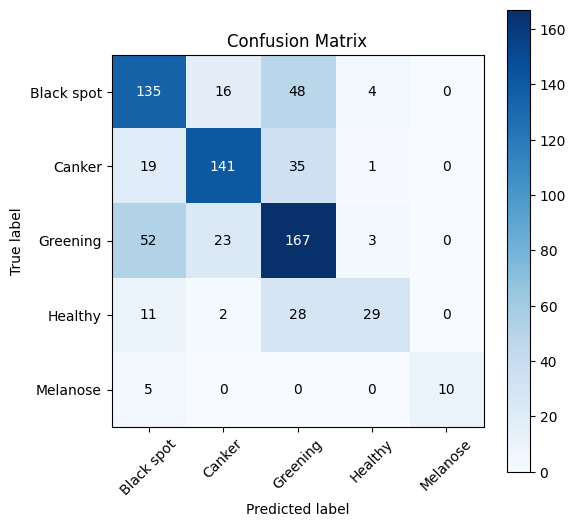

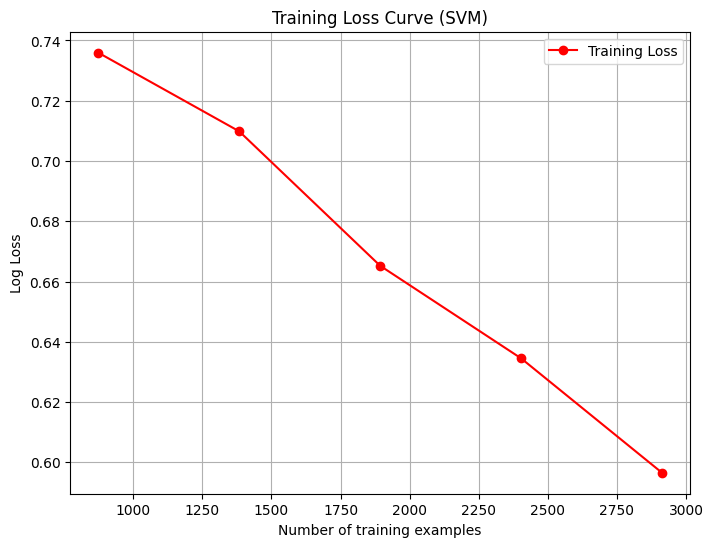

All outputs saved to: /content/op2


In [30]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd2"           # your input preprocessed images
output_dir = "/content/op2"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', color='red', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)


3. GrabCut + Photometric Augumentation

In [14]:
import cv2
import numpy as np
import os
import random

# 🔹 Input & Output Directories
input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd3"
os.makedirs(output_dir, exist_ok=True)

# 🌿 Background Removal – GrabCut Algorithm
def remove_background(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, img.shape[1]-10, img.shape[0]-10)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    return img * mask2[:, :, np.newaxis]

# 🌈 Photometric Augmentation Functions
def photometric_transform(img):
    # Convert to HSV for hue and saturation adjustments
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Random Hue Shift
    hue_shift = random.uniform(-10, 10)  # degrees
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180

    # Random Saturation / Color Jitter
    sat_scale = random.uniform(0.8, 1.2)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)

    # Convert back to BGR
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    # Gamma Correction
    gamma = random.uniform(0.7, 1.3)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
    img = cv2.LUT(img, table)

    return img

# 🔄 Apply GrabCut + Photometric Augmentations
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)

    print(f"Processing class: {cls}")

    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Step 1: Background Removal
        bg_removed = remove_background(img)

        # Save the background-removed image
        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, bg_removed)

        # Step 2: Generate 5 Photometric Transformations
        for i in range(5):
            aug_img = photometric_transform(bg_removed)
            aug_save_path = os.path.join(cls_output_path, f"photo_aug_{i}_{img_file}")
            cv2.imwrite(aug_save_path, aug_img)

print("✅ Background removal + photometric augmentations complete.")
print("Output dataset saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Background removal + photometric augmentations complete.
Output dataset saved to: /content/sd3


Loaded 3642 images from /content/sd3
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (3642, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


Saved SOM assignments: /content/op3/som_assignments.npy

Metrics:
 Samples: 3642
Train: 2913
Test: 729
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.8038
Precision: 0.8155
Recall: 0.8038
F1 Score: 0.8049
Specificity (avg): 0.9447
MAE: 0.3621
RMSE: 0.8904



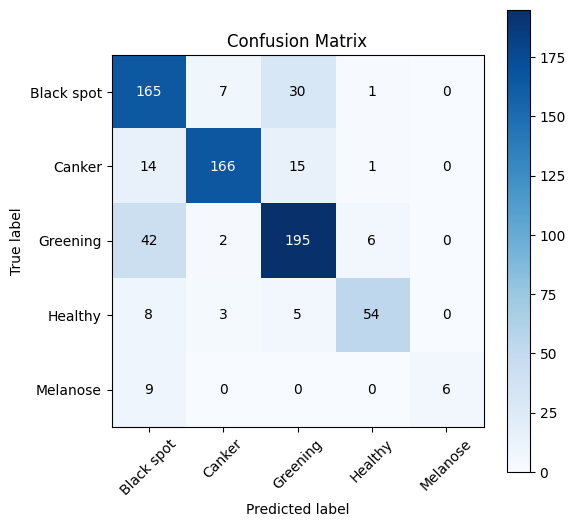

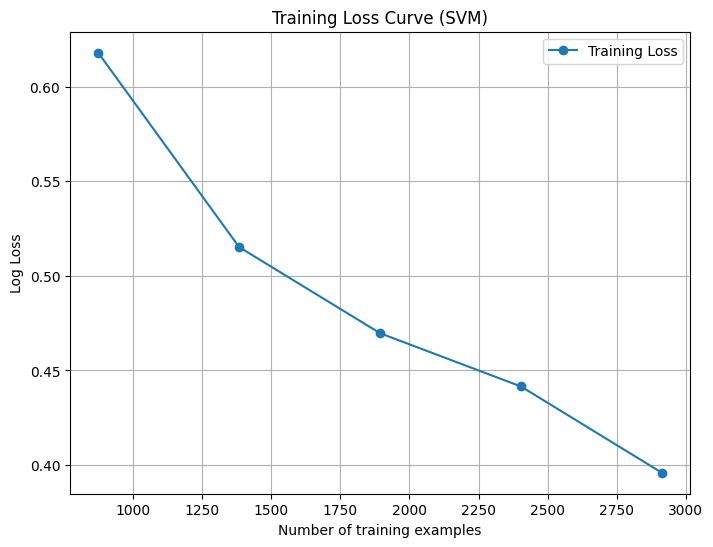

All outputs saved to: /content/op3


In [22]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd3"           # your input preprocessed images
output_dir = "/content/op3"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)


4. Otsu’s Thresholding + Robust Model

In [23]:
import cv2
import numpy as np
import os

# 🔹 Input & Output Directories
input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd4"
os.makedirs(output_dir, exist_ok=True)

# 🌿 Otsu Threshold + Robust Foreground Extraction
def otsu_robust(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu's thresholding
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert mask if needed (leaf = white)
    if np.mean(gray[mask==255]) < np.mean(gray[mask==0]):
        mask = cv2.bitwise_not(mask)
    # Keep only largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = np.uint8(labels == largest_label) * 255
    return cv2.bitwise_and(img, img, mask=mask)

# 🔄 Apply to all images
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)
    print(f"Processing class: {cls}")
    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        robust_img = otsu_robust(img)
        save_path = os.path.join(cls_output_path, img_file)
        cv2.imwrite(save_path, robust_img)

print("✅ Otsu + Robust Model complete. Output saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Otsu + Robust Model complete. Output saved to: /content/sd4


Loaded 607 images from /content/sd4
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (607, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Saved SOM assignments: /content/op4/som_assignments.npy

Metrics:
 Samples: 607
Train: 485
Test: 122
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.3934
Precision: 0.3350
Recall: 0.3934
F1 Score: 0.3366
Specificity (avg): 0.8233
MAE: 0.8443
RMSE: 1.1559



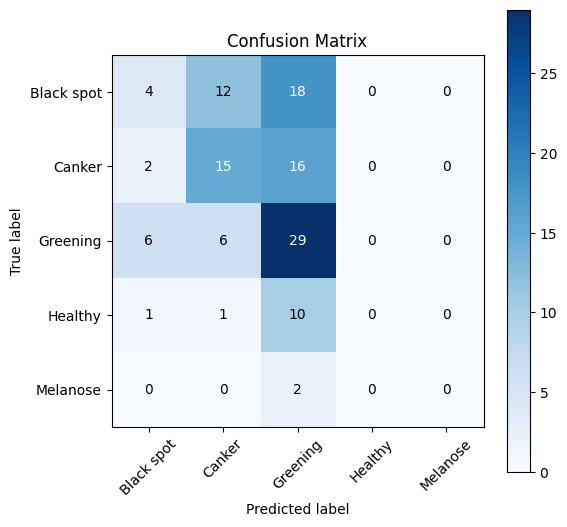

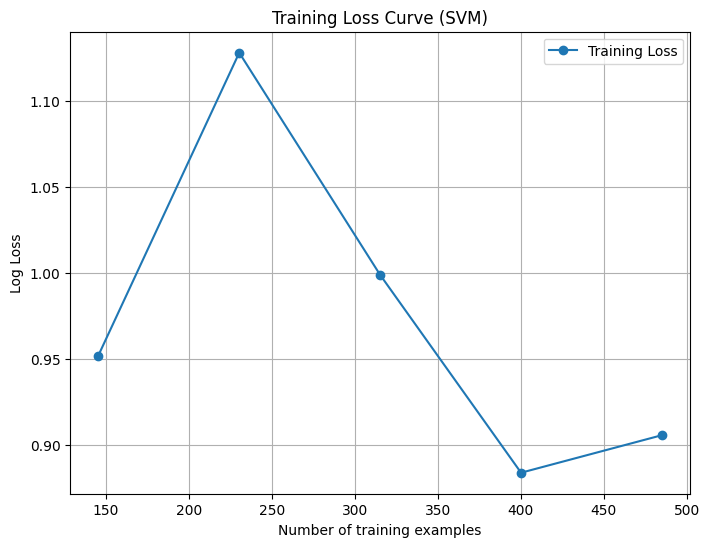

All outputs saved to: /content/op4


In [24]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd4"           # your input preprocessed images
output_dir = "/content/op4"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)


5. Otsu’s Thresholding + Geometric Transform

In [25]:
import cv2
import numpy as np
import os
import random

input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd5"
os.makedirs(output_dir, exist_ok=True)

def otsu_seg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(gray[mask==255]) < np.mean(gray[mask==0]):
        mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(img, img, mask=mask)

def geometric_transform(img):
    h, w = img.shape[:2]
    # Random rotation (-30 to 30 degrees)
    angle = random.uniform(-30, 30)
    M_rot = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img = cv2.warpAffine(img, M_rot, (w, h))

    # Random flip
    flip_code = random.choice([-1, 0, 1, None])
    if flip_code is not None:
        img = cv2.flip(img, flip_code)

    # Random scale
    scale = random.uniform(0.8, 1.2)
    img = cv2.resize(img, None, fx=scale, fy=scale)
    # Crop/Pad to original size
    img = cv2.resize(img, (w, h))

    # Random translation
    tx = random.randint(-10, 10)
    ty = random.randint(-10, 10)
    M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M_trans, (w, h))

    return img

# 🔄 Process all images
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)
    print(f"Processing class: {cls}")
    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        base_img = otsu_seg(img)
        # Save original segmented image
        cv2.imwrite(os.path.join(cls_output_path, img_file), base_img)
        # Apply 5 geometric variations
        for i in range(5):
            aug_img = geometric_transform(base_img)
            aug_save_path = os.path.join(cls_output_path, f"geo_aug_{i}_{img_file}")
            cv2.imwrite(aug_save_path, aug_img)

print("✅ Otsu + Geometric Transform complete. Output saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Otsu + Geometric Transform complete. Output saved to: /content/sd5


Loaded 3642 images from /content/sd5
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (3642, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


Saved SOM assignments: /content/op5/som_assignments.npy

Metrics:
 Samples: 3642
Train: 2913
Test: 729
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.6872
Precision: 0.7138
Recall: 0.6872
F1 Score: 0.6824
Specificity (avg): 0.9092
MAE: 0.4815
RMSE: 0.9200



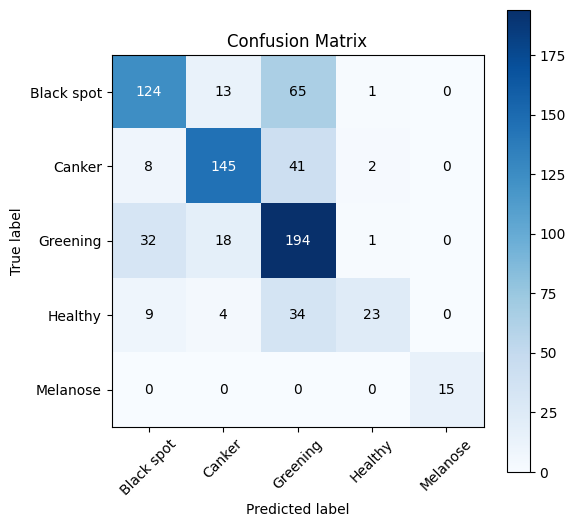

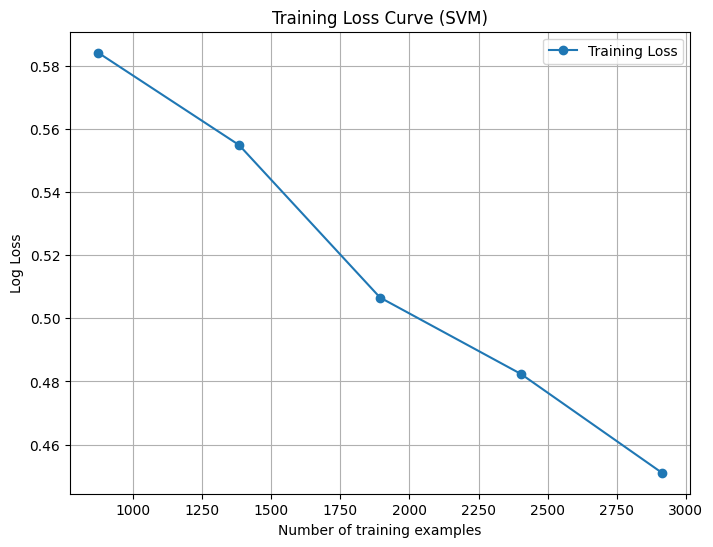

All outputs saved to: /content/op5


In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd5"           # your input preprocessed images
output_dir = "/content/op5"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)


6. Otsu’s Thresholding + Photometric augmentation

In [27]:
import cv2
import numpy as np
import os
import random

input_dir = "/content/citrus_preprocessed"
output_dir = "/content/sd6"
os.makedirs(output_dir, exist_ok=True)

def otsu_seg(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(gray[mask==255]) < np.mean(gray[mask==0]):
        mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(img, img, mask=mask)

def photometric_transform(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hue_shift = random.uniform(-10, 10)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180
    sat_scale = random.uniform(0.8, 1.2)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    gamma = random.uniform(0.7, 1.3)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(256)]).astype("uint8")
    img = cv2.LUT(img, table)
    return img

# 🔄 Process all images
for cls in os.listdir(input_dir):
    cls_input_path = os.path.join(input_dir, cls)
    cls_output_path = os.path.join(output_dir, cls)
    if not os.path.isdir(cls_input_path):
        continue
    os.makedirs(cls_output_path, exist_ok=True)
    print(f"Processing class: {cls}")
    for img_file in os.listdir(cls_input_path):
        img_path = os.path.join(cls_input_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        base_img = otsu_seg(img)
        # Save original segmented image
        cv2.imwrite(os.path.join(cls_output_path, img_file), base_img)
        # Apply 5 photometric variations
        for i in range(5):
            aug_img = photometric_transform(base_img)
            aug_save_path = os.path.join(cls_output_path, f"photo_aug_{i}_{img_file}")
            cv2.imwrite(aug_save_path, aug_img)

print("✅ Otsu + Photometric Augmentation complete. Output saved to:", output_dir)


Processing class: Canker
Processing class: Greening
Processing class: Melanose
Processing class: Healthy
Processing class: Black spot
✅ Otsu + Photometric Augmentation complete. Output saved to: /content/sd6


Loaded 3642 images from /content/sd6
Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
Using EfficientNetB0 with ImageNet weights.
Features shape: (3642, 1280)
Training SOM...


SOM Training Epochs: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Saved SOM assignments: /content/op6/som_assignments.npy

Metrics:
 Samples: 3642
Train: 2913
Test: 729
Classes: [np.str_('Black spot'), np.str_('Canker'), np.str_('Greening'), np.str_('Healthy'), np.str_('Melanose')]

Accuracy: 0.8587
Precision: 0.8609
Recall: 0.8587
F1 Score: 0.8588
Specificity (avg): 0.9599
MAE: 0.2195
RMSE: 0.6285



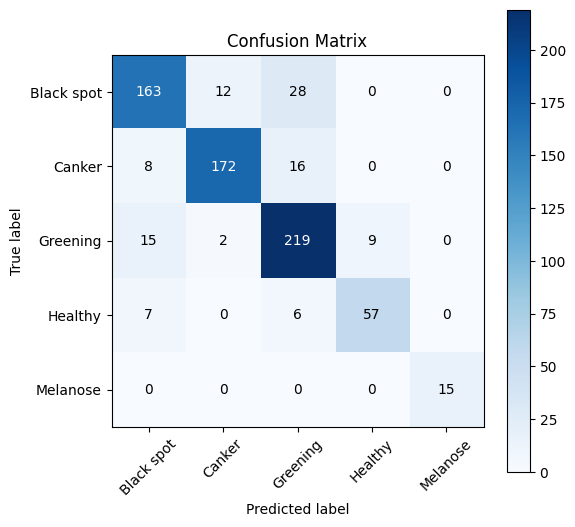

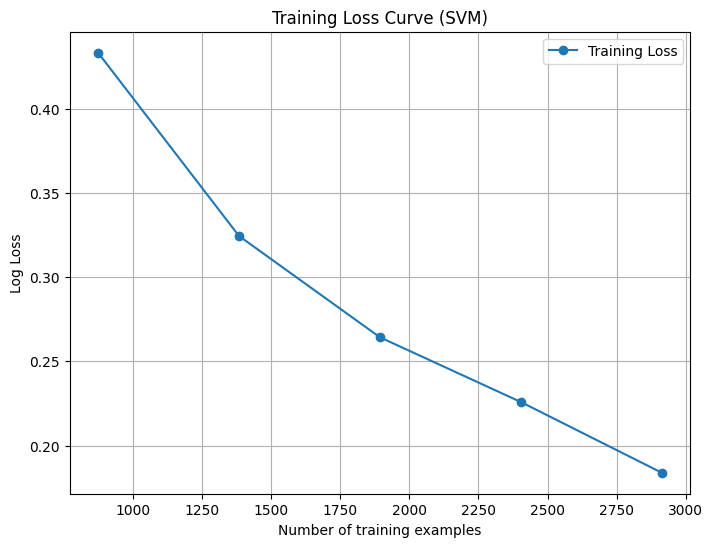

All outputs saved to: /content/op6


In [28]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error, log_loss)
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

# --- TensorFlow/Keras imports ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Paths
input_dir = "/content/sd6"           # your input preprocessed images
output_dir = "/content/op6"          # where all outputs will be saved
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# Load images & labels
IMG_SIZE = (224, 224)
X_images, y_labels, class_names = [], [], []

for cls in sorted(os.listdir(input_dir)):
    cls_path = os.path.join(input_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    class_names.append(cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            p = os.path.join(cls_path, f)
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X_images.append(img)
            y_labels.append(cls)

if len(X_images) == 0:
    raise RuntimeError(f"No images found in {input_dir}.")

X = np.array(X_images, dtype="float32")
y = np.array(y_labels)
print(f"Loaded {X.shape[0]} images from {input_dir}")
print("Classes:", class_names)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# -------------------------
# EfficientNet feature extractor
try:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet',
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetB0 with ImageNet weights.")
except Exception:
    efficientnet80_feature_extractor = EfficientNetB0(include_top=False, pooling='avg', weights=None,
                                                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("No internet, using EfficientNetB0 with random weights.")

def extract_features(batch):
    x = preprocess_input(batch.copy())
    return efficientnet80_feature_extractor.predict(x, verbose=0)

batch_size = 32
features_list = []
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    feats = extract_features(batch)
    features_list.append(feats)
features = np.vstack(features_list)
print("Features shape:", features.shape)

# -------------------------
# Simple SOM implementation (training only, no plot)
class SimpleSOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha_start=0.5, sigma_start=None):
        self.m, self.n, self.dim = m, n, dim
        self.n_iterations = n_iterations
        self.alpha_start = alpha_start
        self.sigma_start = sigma_start if sigma_start is not None else max(m, n)/2.0
        self.weights = np.random.randn(m*n, dim).astype(np.float32)
        self.neuron_pos = np.array([[i, j] for i in range(m) for j in range(n)])
    def train(self, data):
        for it in tqdm(range(self.n_iterations), desc="SOM Training Epochs"):
            alpha = self.alpha_start * (1 - it / self.n_iterations)
            sigma = self.sigma_start * (1 - it / self.n_iterations)
            idxs = np.random.permutation(data.shape[0])
            for i in idxs:
                x = data[i]
                dists = np.linalg.norm(self.weights - x, axis=1)
                bmu_idx = np.argmin(dists)
                bmu_pos = self.neuron_pos[bmu_idx]
                dif = self.neuron_pos - bmu_pos
                sqd = np.sum(dif**2, axis=1)
                h = np.exp(-sqd / (2 * (sigma**2)))
                self.weights += (alpha * h[:, np.newaxis]) * (x - self.weights)
        return self
    def map_vectors(self, data):
        assignments = []
        for x in data:
            dists = np.linalg.norm(self.weights - x, axis=1)
            assignments.append(np.argmin(dists))
        return np.array(assignments)

som = SimpleSOM(10, 10, features.shape[1], n_iterations=50, alpha_start=0.5)
print("Training SOM...")
som.train(features)
som_assign = som.map_vectors(features)
np.save(os.path.join(output_dir, "som_assignments.npy"), som_assign)
print("Saved SOM assignments:", os.path.join(output_dir, "som_assignments.npy"))

# -------------------------
# SVM classification
X_train, X_test, y_train, y_test = train_test_split(features, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
joblib.dump(svm, os.path.join(output_dir, "svm_model.pkl"))

y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificities = []
for i in range(cm.shape[0]):
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN
    specificities.append(TN / (TN + FP) if (TN + FP) > 0 else 0)
specificity_avg = np.mean(specificities)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

metrics_text = (
    f"Samples: {len(y_enc)}\n"
    f"Train: {len(y_train)}\n"
    f"Test: {len(y_test)}\n"
    f"Classes: {list(le.classes_)}\n\n"
    f"Accuracy: {acc:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall: {rec:.4f}\n"
    f"F1 Score: {f1:.4f}\n"
    f"Specificity (avg): {specificity_avg:.4f}\n"
    f"MAE: {mae:.4f}\n"
    f"RMSE: {rmse:.4f}\n"
)
print("\nMetrics:\n", metrics_text)

with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
    f.write(metrics_text)

# -------------------------
# Confusion matrix plot with numbers inside
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
classes = le.classes_
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

# -------------------------
# Training loss curve (manual log loss computation)
train_sizes_frac = np.linspace(0.3, 1.0, 5)
train_loss_mean = []

for frac in train_sizes_frac:
    X_sub, y_sub = resample(X_train, y_train, n_samples=int(frac*len(X_train)),
                            stratify=y_train, random_state=42)
    svm_sub = SVC(kernel='rbf', probability=True, random_state=42)
    svm_sub.fit(X_sub, y_sub)
    y_pred_proba = svm_sub.predict_proba(X_sub)
    loss = log_loss(y_sub, y_pred_proba, labels=np.arange(len(class_names)))
    train_loss_mean.append(loss)

plt.figure(figsize=(8,6))
plt.plot(train_sizes_frac*len(X_train), train_loss_mean, marker='o', label='Training Loss')
plt.xlabel("Number of training examples")
plt.ylabel("Log Loss")
plt.title("Training Loss Curve (SVM)")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_loss_curve.png"))
plt.show()

# -------------------------
# Save arrays
np.save(os.path.join(output_dir, "confusion_matrix.npy"), cm)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)
np.save(os.path.join(output_dir, "y_pred.npy"), y_pred)

print("All outputs saved to:", output_dir)
